In [173]:
import matplotlib.cm as cm
import pandas as pd

In [174]:
df = pd.read_csv('metadata_classified.csv')
df_clean = df.dropna(subset=["gender", "race"])

real = df_clean[df_clean["target"] == 1]
fake = df_clean[df_clean["target"] == 0]

In [175]:
def gender_distribution(df: pd.DataFrame, column: str = "gender"):
    plt.figure(figsize=(10, 6))

    gender_labels = df[column].unique()
    gender_counts = [(df[column] == label).sum() for label in gender_labels]

    total_rows = len(df)
    gender_percentages = [count * 100 / total_rows for count in gender_counts]

    bars = plt.bar(gender_labels, gender_counts, color=["red", "blue"])

    for bar, pct in zip(bars, gender_percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{pct:.1f}%",
                 ha='center', va='bottom')

    plt.title("Gender Distribution")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def race_distribution(df: pd.DataFrame, column: str = "race"):
    plt.figure(figsize=(10, 6))

    race_labels = df[column].dropna().unique()
    race_counts = [(df[column] == label).sum() for label in race_labels]

    total_rows = len(df)
    race_percentages = [count * 100 / total_rows for count in race_counts]

    cmap = plt.get_cmap('tab20', len(race_labels))
    colors = [cmap(i) for i in range(len(race_labels))]

    bars = plt.bar(race_labels, race_counts, color=colors)

    for bar, pct in zip(bars, race_percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{pct:.1f}%",
                 ha='center', va='bottom')

    plt.title("Race Distribution")
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def race_gender_distribution(df: pd.DataFrame, race_col: str = "race", gender_col: str = "gender"):
    # Create crosstab (race vs gender)
    crosstab = pd.crosstab(df[race_col], df[gender_col])

    race_labels = crosstab.index.tolist()
    gender_labels = crosstab.columns.tolist()
    bar_width = 0.8 / len(gender_labels)

    x = np.arange(len(race_labels))

    total = crosstab.values.sum()  # Total for percentage calculation

    plt.figure(figsize=(12, 6))

    for i, gender in enumerate(gender_labels):
        counts = crosstab[gender].values
        bars = plt.bar(x + i * bar_width, counts, width=bar_width, label=str(gender))

        # Add percentages on top of each bar
        for bar in bars:
            height = bar.get_height()
            pct = (height / total) * 100 if total > 0 else 0
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{pct:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9
            )

    plt.xticks(x + bar_width * (len(gender_labels) - 1) / 2, race_labels, rotation=45, ha='right')
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.title("Race and Gender Distribution")
    plt.legend(title="Gender")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Real Statistics

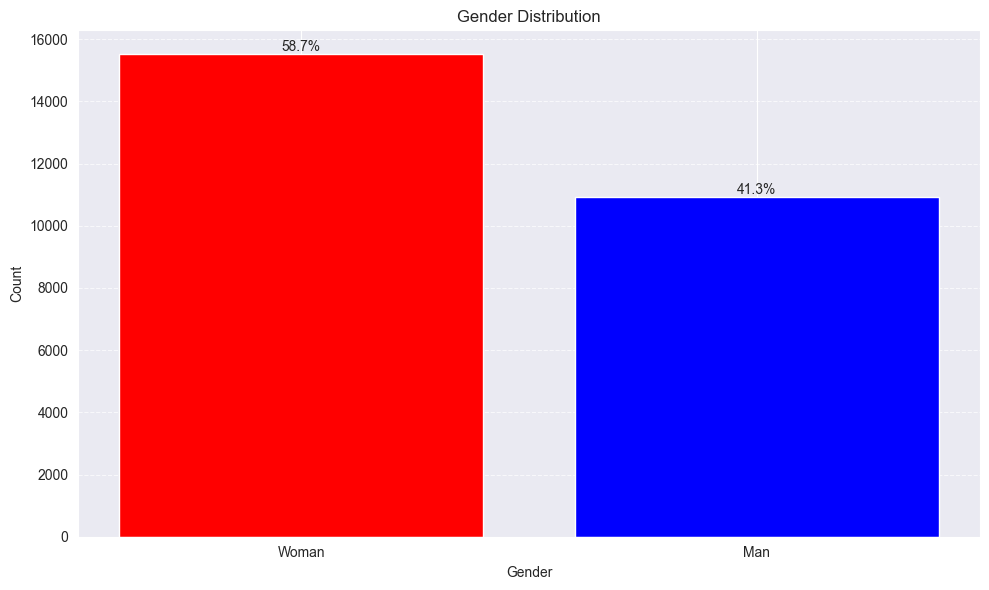

In [176]:
gender_distribution(real)

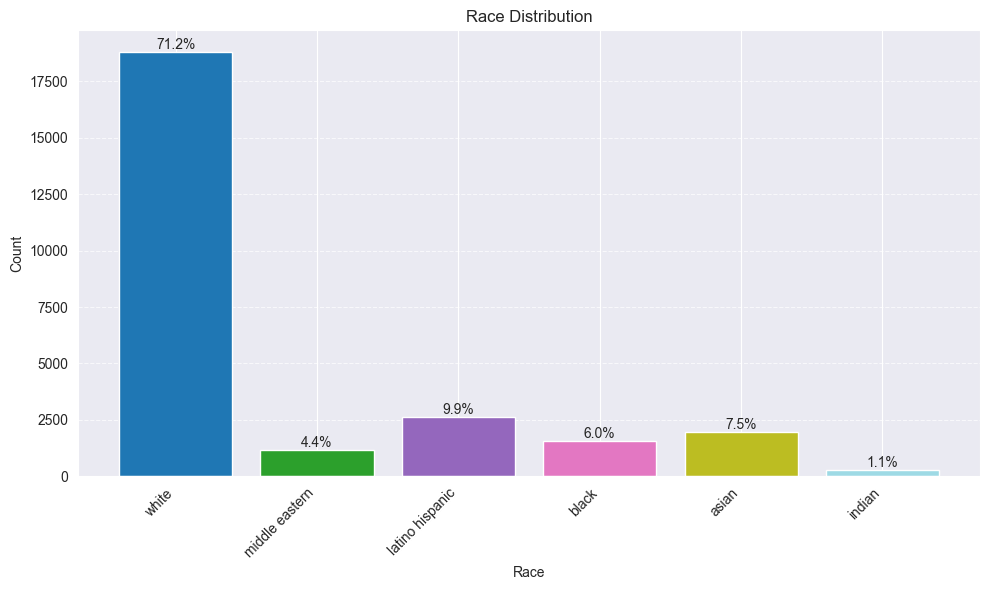

In [177]:
race_distribution(real)

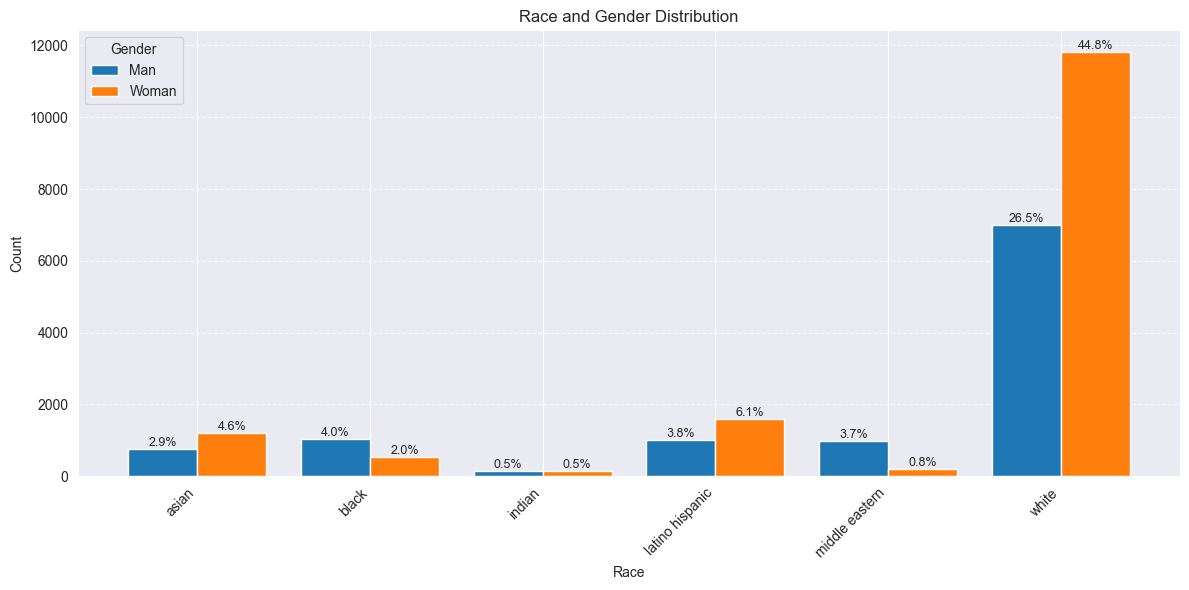

In [178]:
race_gender_distribution(real)

# Fake

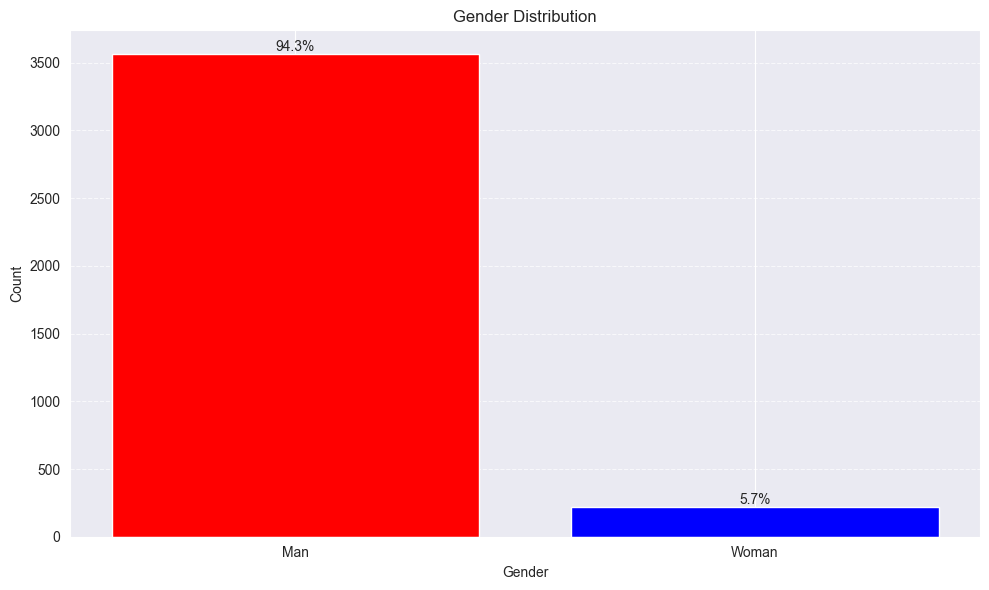

In [179]:
gender_distribution(fake)

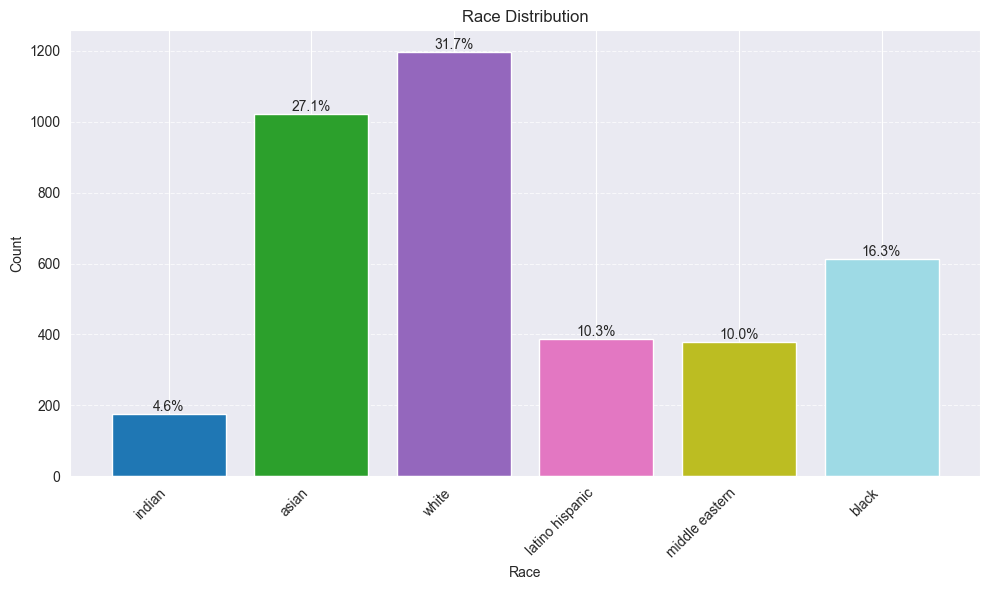

In [180]:
race_distribution(fake)

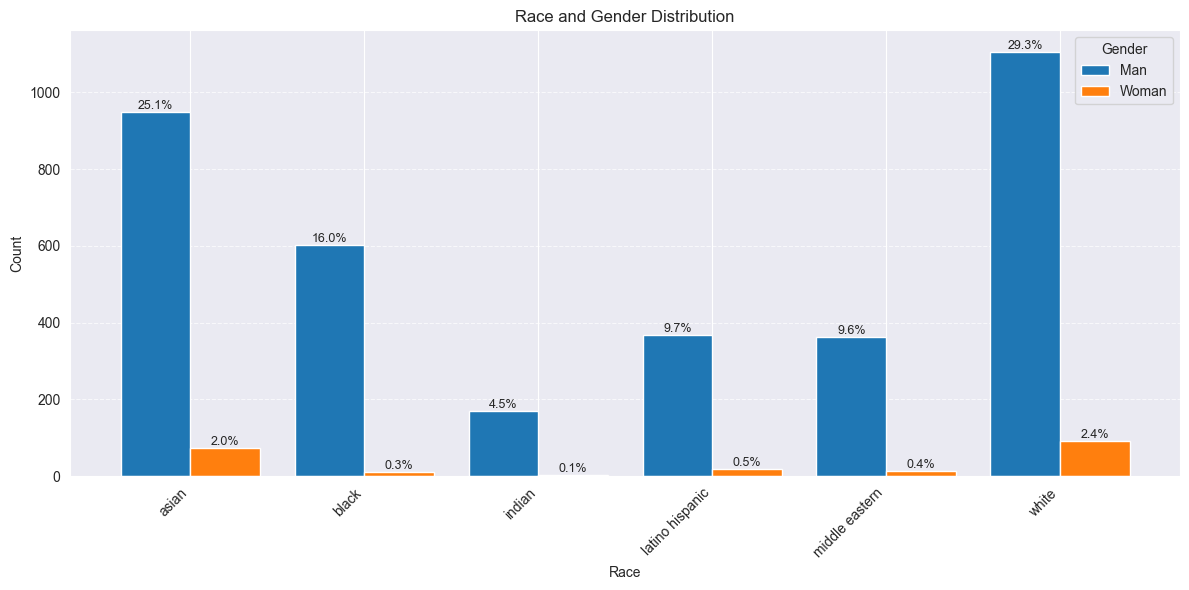

In [181]:
race_gender_distribution(fake)

# Balancing

In [182]:
def downsample_majority_race(df: pd.DataFrame, race_col: str = "race", gender_col: str = "gender",
                             majority_race: str = "white", target_fraction: float = 0.10):
    total_rows = len(df)
    target_white_count = int(total_rows * target_fraction)

    white_df = df[df[race_col] == majority_race]
    non_white_df = df[df[race_col] != majority_race]

    # Maintain gender ratio within white_df
    white_gender_counts = white_df[gender_col].value_counts(normalize=True)

    sampled_white = pd.concat([
        white_df[white_df[gender_col] == gender].sample(
            n=int(target_white_count * proportion),
            random_state=42
        )
        for gender, proportion in white_gender_counts.items()
    ])

    # Combine with non-white data
    balanced_df = pd.concat([non_white_df, sampled_white]).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df


In [183]:
fake_female_count = len(fake[fake["gender"] == "female"])
# reduce male and female count (both in real and fake) to fake_female_count
balanced_real = downsample_majority_race(real, race_col="race", gender_col="gender", majority_race="white",
                                         target_fraction=0.10)

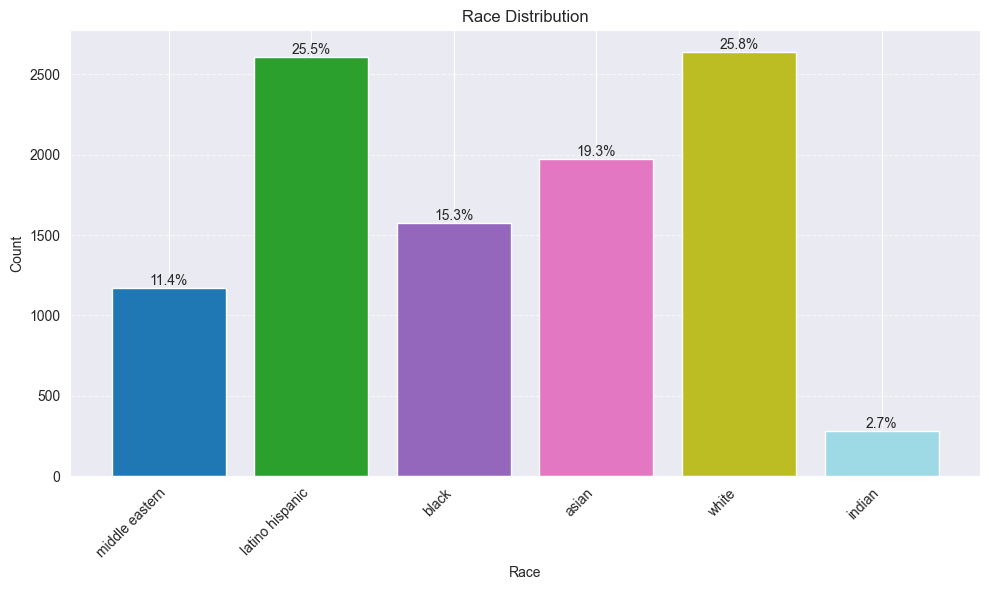

In [184]:
race_distribution(balanced_real)

In [185]:
import os
import random
from PIL import Image
from tqdm import tqdm

import numpy as np
import torch
import pandas as pd
from torchvision.transforms import v2

# Set seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Augmentation setup
augment_transform = v2.RandomApply([
    v2.RandomHorizontalFlip(p=1),
    v2.RandomVerticalFlip(p=1),
    v2.RandomRotation(degrees=(0, 270))
])
pil_to_tensor = v2.PILToTensor()
tensor_to_pil = v2.ToPILImage()

# Parameters
dataset_dir = "dataset"
target_race_percentage = 20  # desired percentage of the full dataset per race
target_races = ["indian", "black", "middle eastern", "asian"]  # races to augment

def balance_race_gender(df, target_race, target_percentage):
    race_df = df[df["race"] == target_race]
    total_dataset_size = len(df)
    
    # Compute how many images needed to reach target %
    target_total_count = int((target_percentage / 100) * total_dataset_size)
    target_gender_count = target_total_count // 2

    # Split by gender
    gender_groups = {
        "woman": race_df[race_df["gender"].str.lower() == "woman"],
        "man": race_df[race_df["gender"].str.lower() == "man"]
    }

    # Load existing images into tensors
    tensor_images = {"woman": [], "man": []}
    for gender in ["woman", "man"]:
        for _, row in tqdm(gender_groups[gender].iterrows(), desc=f"Loading {gender} images ({target_race})", total=len(gender_groups[gender])):
            image = Image.open(os.path.join(dataset_dir, row["img_path"]))
            tensor_images[gender].append(pil_to_tensor(image))

    # Determine how many new images needed per gender
    aug_needed = {
        gender: max(0, target_gender_count - len(tensor_images[gender]))
        for gender in ["woman", "man"]
    }

    # Augment and store tensors
    last_id = get_last_image_id(dataset_dir)

    new_rows = []
    for gender in ["woman", "man"]:
        with tqdm(total=aug_needed[gender], desc=f"Augmenting {gender} ({target_race})") as pbar:
            for _ in range(aug_needed[gender]):
                base_img = random.choice(tensor_images[gender])
                aug_img = augment_transform(base_img)
                tensor_images[gender].append(aug_img)

                last_id += 1
                filename = f"img{last_id}.jpg"
                path = os.path.join(dataset_dir, filename)
                # tensor_to_pil(aug_img).save(path)

                new_rows.append([filename, path, 1, gender.capitalize(), target_race])
                pbar.update(1)

    # Append all new metadata rows
    return pd.concat([df, pd.DataFrame(new_rows, columns=df.columns)], ignore_index=True)


def get_last_image_id(folder):
    filenames = [f for f in os.listdir(folder) if f.startswith("img") and f.endswith(".jpg")]
    if not filenames:
        return 0
    return max(int(f.split("img")[1].split(".")[0]) for f in filenames)


# Apply to all target races
for race in target_races:
    balanced_real = balance_race_gender(balanced_real, race, target_race_percentage)


Augmenting man (asian): 100%|██████████| 663/663 [00:00<00:00, 1188.11it/s]


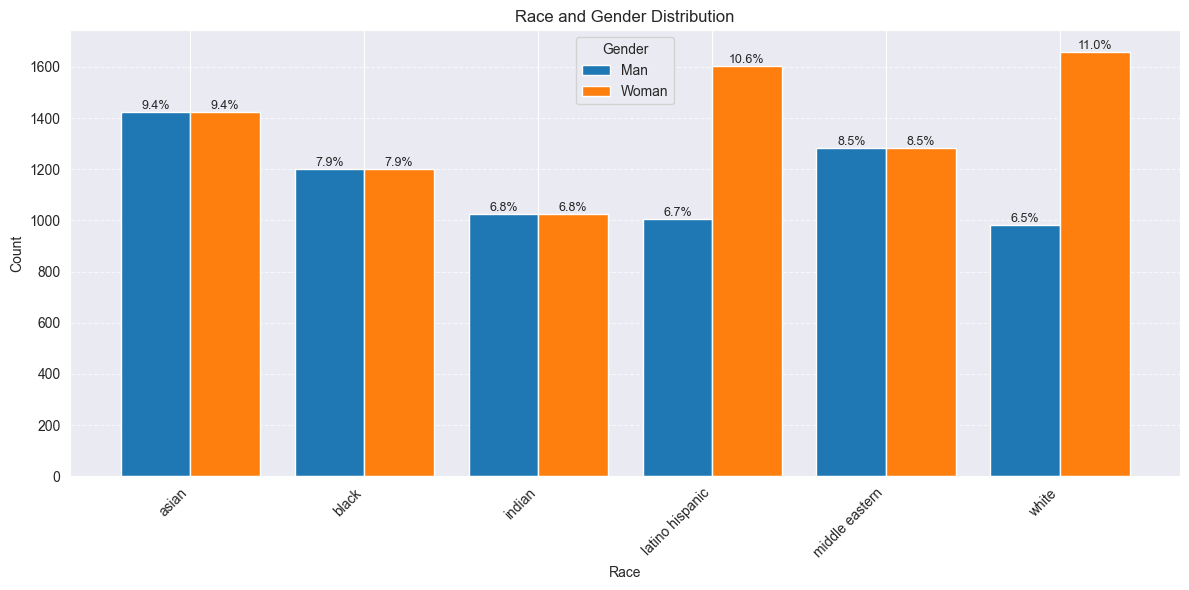

In [186]:
race_gender_distribution(balanced_real)

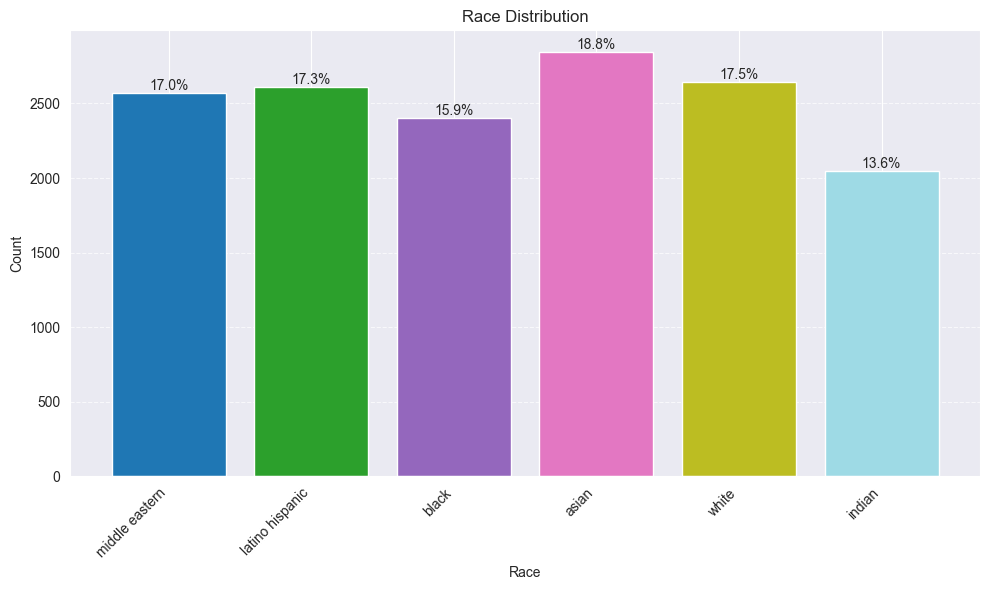

In [187]:
race_distribution(balanced_real)

In [188]:
target_races = ["indian", "black", "latino hispanic", "middle eastern"]
# Apply to all target races
for race in target_races:
    fake = balance_race_gender(fake, race, target_race_percentage)

Augmenting woman (black): 100%|██████████| 424/424 [00:00<00:00, 965.44it/s] 
Augmenting man (black): 0it [00:00, ?it/s]
Augmenting man (middle eastern): 100%|██████████| 170/170 [00:00<00:00, 964.21it/s] 


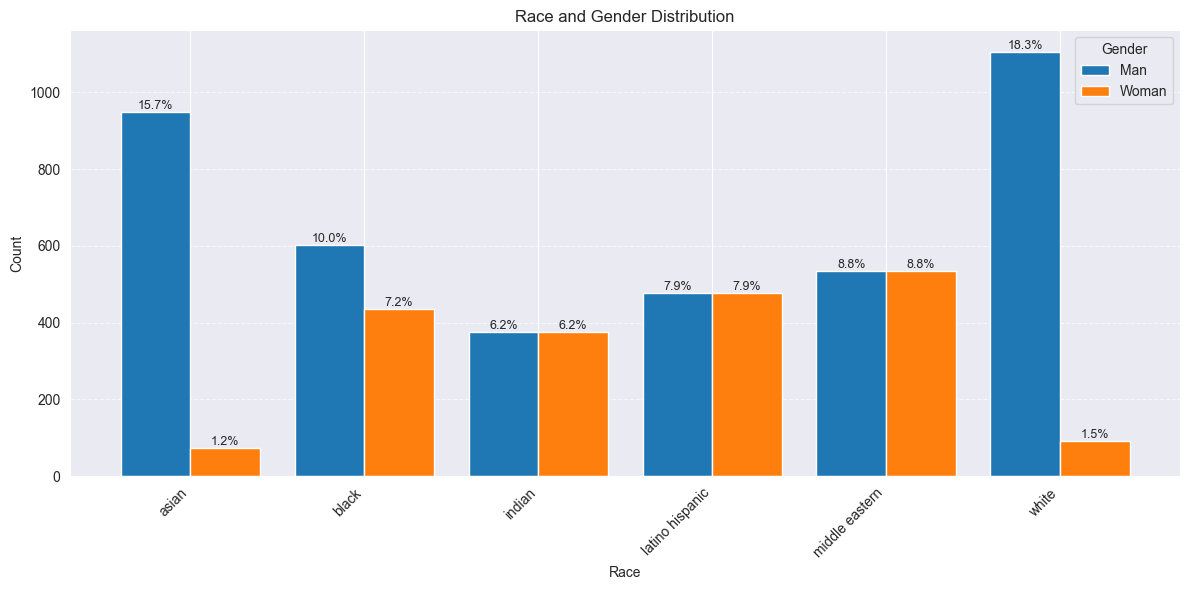

In [189]:
race_gender_distribution(fake)

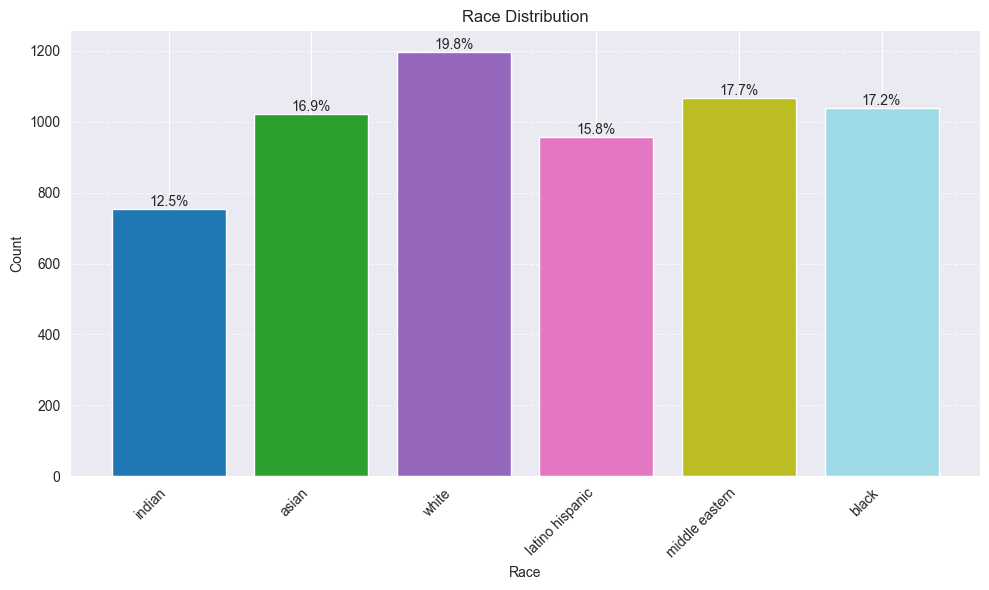

In [190]:
race_distribution(fake)

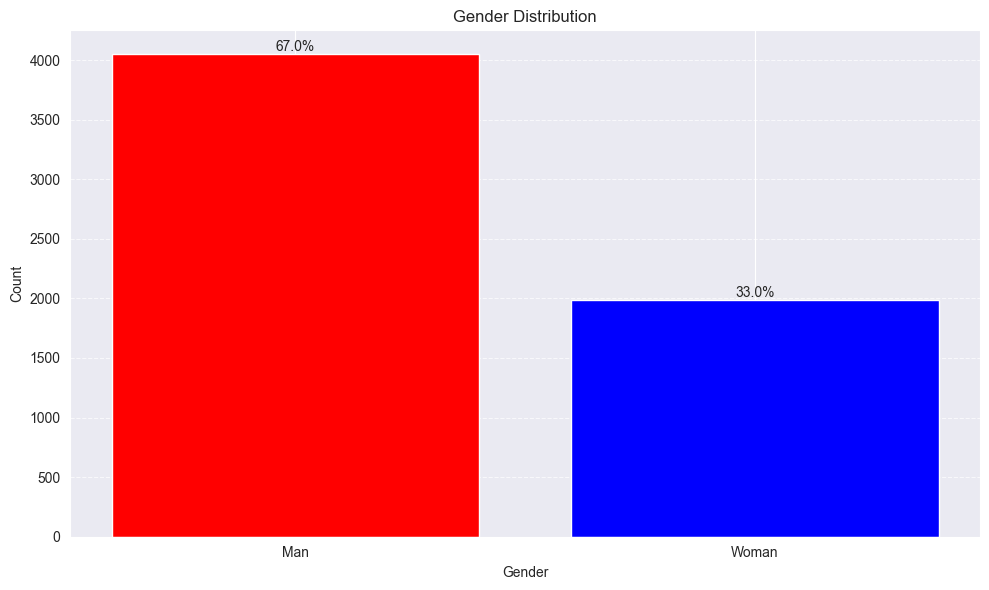

In [191]:
gender_distribution(fake)

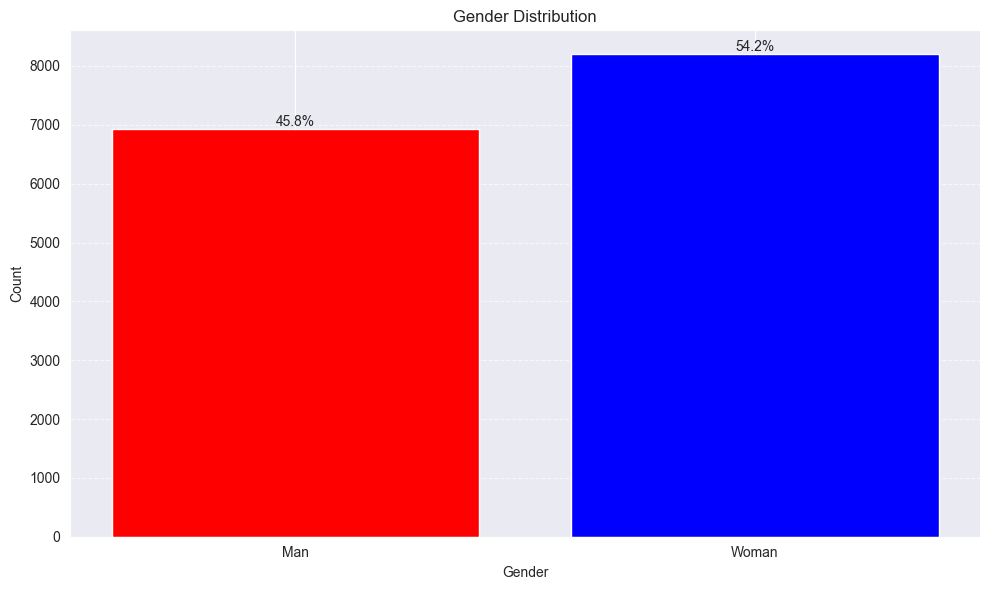

In [192]:
gender_distribution(balanced_real)